A continuación se presenta una guía estilo notebook con explicaciones, derivaciones matemáticas y ejemplos visuales para ilustrar el procedimiento de estimación no paramétrica de las funciones de deriva (drift) y difusión a partir de datos que representan una trayectoria discreta de un proceso estocástico que satisface la ecuación diferencial estocástica (EDE):


$$dX_t = a(X_t, t)\,dt + b(X_t, t)\, dW_t,$$


donde  $X_t$  es el estado del proceso en el tiempo  t , $ a(\cdot,\cdot)$  es la función de deriva,  $b(\cdot,\cdot)$  es la función de difusión, y  $W_t$  es un proceso de Wiener estándar (Browniano).

### Idea General

Tenemos una trayectoria observada  $\{ X_{t_i} \}_{i=0}^n$  del proceso, donde  $t_0 < t_1 < \dots < t_n$  son los tiempos de muestreo. Queremos estimar  $a(x,t)$  y  $b(x,t)$  usando técnicas no paramétricas.

La estrategia clásica es la siguiente:

1.	Discretización del incrementos:

Del modelo:

$$X_{t+\Delta t} - X_t = a(X_t, t)\Delta t + b(X_t, t)\Delta W_t$$

Donde $\Delta W_t \sim \mathcal{N}(0, \Delta t)$.
Para pequeños $\Delta t = t_{i+1}-t_i$, podemos aproximar:

$$\Delta X_i := X_{t_{i+1}} - X_{t_i} \approx a(X_{t_i}, t_i)\Delta t + b(X_{t_i}, t_i)\sqrt{\Delta t} Z_i$$

con  $Z_i \sim \mathcal{N}(0,1)$ .

2.	Estimación de  $a(x,t)$ :

Considerando el promedio condicional:

$$\mathbb{E}[\Delta X_i \mid X_{t_i}=x, t_i = t] \approx a(x,t)\Delta t$$

Luego,

$$a(x,t) \approx \frac{\mathbb{E}[\Delta X_i \mid X_{t_i} \approx x, t_i \approx t]}{\Delta t}$$

De manera no paramétrica, podemos usar métodos de suavizado (por ejemplo, kernel smoothing) sobre los pares $(X_{t_i}, t_i)$ para estimar la media condicional de $\Delta X_i$.

3.	Estimación de  $b(x,t)$ :

De la varianza condicional se tiene:

$$\text{Var}(\Delta X_i \mid X_{t_i}=x, t_i=t) = b(x,t)^2 \Delta t$$

Por lo que:

$$b(x,t) \approx \sqrt{\frac{\text{Var}(\Delta X_i \mid X_{t_i} \approx x, t_i \approx t)}{\Delta t}}$$

Nuevamente, de forma no paramétrica, se puede estimar la varianza condicional de $\Delta X_i$ dado $X_{t_i}\approx x y t_i \approx t$.

4.	No parámétrico (Kernel Smoothing):

Una técnica típica es usar un kernel estimator en el espacio de estados y tiempo. Por ejemplo, definimos un kernel bidimensional  $K_h(\cdot,\cdot)$  con ancho de ventana  h . Para un punto $(x,t)$:

$$\hat{a}(x,t) = \frac{\sum_i K_h(X_{t_i}-x, t_i-t)\Delta X_i}{\sum_i K_h(X_{t_i}-x, t_i-t)\Delta t}$$

Análogamente:

$$\hat{b}(x,t)^2 = \frac{\sum_i K_h(X_{t_i}-x, t_i-t)(\Delta X_i - \hat{a}(x,t)\Delta t)^2}{\sum_i K_h(X_{t_i}-x, t_i-t)} \frac{1}{\Delta t}$$

Y finalmente:

$$\hat{b}(x,t) = \sqrt{\hat{b}(x,t)^2}$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

In [2]:
# Parámetros de la simulación
np.random.seed(123)
T = 10.0   # tiempo total
n = 10000  # número de pasos
dt = T/n
t = np.linspace(0, T, n+1)

# Verdaderas funciones de drift y difusión:
def a_true(x, t):
    return 0.5 * x

def b_true(x, t):
    return 0.3 * np.ones_like(x)

# Simulación de Euler-Maruyama
X = np.zeros(n+1)
X[0] = 1.0  # condición inicial
for i in range(n):
    X[i+1] = X[i] + a_true(X[i], t[i])*dt + b_true(X[i], t[i])*np.sqrt(dt)*np.random.randn()

# Incrementos
dX = X[1:] - X[:-1]
t_mid = t[:-1]

In [3]:
# Definir el rango del estado
x_min, x_max = np.min(X), np.max(X)
num_bins = 50
bins = np.linspace(x_min, x_max, num_bins+1)
bin_centers = 0.5*(bins[:-1] + bins[1:])

# Arrays para guardar estimaciones
a_est = np.zeros(num_bins)
b_est = np.zeros(num_bins)

# Asignar a cada punto X[i] un bin
indices = np.digitize(X[:-1], bins) - 1

for j in range(num_bins):
    # Tomar todos los incrementos con X_t en el bin j
    mask = (indices == j)
    if np.sum(mask) > 10:  # asegurarse de tener suficientes puntos
        dX_bin = dX[mask]
        # Estimación a(x) ~ mean(dX)/dt
        a_est[j] = np.mean(dX_bin)/dt
        # Estimación b(x)^2 ~ var(dX)/dt
        b_est[j] = np.sqrt(np.var(dX_bin)/dt)
    else:
        a_est[j] = np.nan
        b_est[j] = np.nan

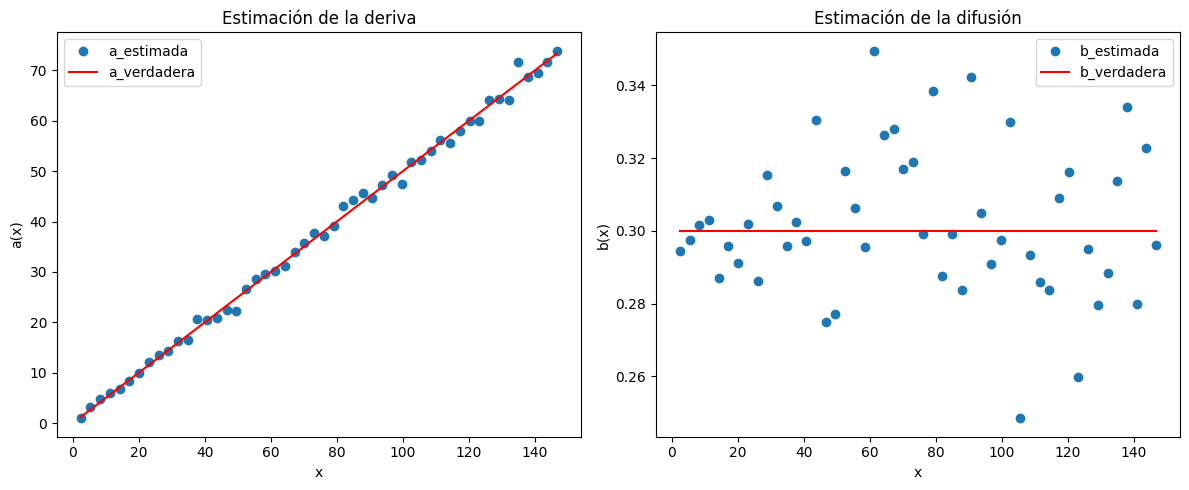

In [4]:
# Valores verdaderos en los centros de los bins
a_true_vals = a_true(bin_centers, 0)
b_true_vals = b_true(bin_centers, 0)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(bin_centers, a_est, 'o', label='a_estimada')
plt.plot(bin_centers, a_true_vals, 'r-', label='a_verdadera')
plt.xlabel('x')
plt.ylabel('a(x)')
plt.title('Estimación de la deriva')
plt.legend()

plt.subplot(1,2,2)
plt.plot(bin_centers, b_est, 'o', label='b_estimada')
plt.plot(bin_centers, b_true_vals, 'r-', label='b_verdadera')
plt.xlabel('x')
plt.ylabel('b(x)')
plt.title('Estimación de la difusión')
plt.legend()

plt.tight_layout()
plt.show()

Estimación no paramétrica

Vamos a discretizar el espacio de estados en una rejilla y utilizar un método simple de kernel smoothing unidimensional para estimar la relación entre $\Delta X$ y $X_t$. Para simplificar, en este ejemplo ignoraremos la dependencia explícita en t, asumiendo que a y b dependen sólo de x. (En un caso más complejo, se puede usar un kernel en el espacio bidimensional $(x,t)$.)

Idea sencilla:

•	Binnea el espacio de estados y, para cada bin, calcula la media y varianza de $\Delta X$.

•	Esto es una aproximación no paramétrica muy básica.

•	Para un enfoque más sofisticado, se usaría kernel smoothing.

Estimación por binning

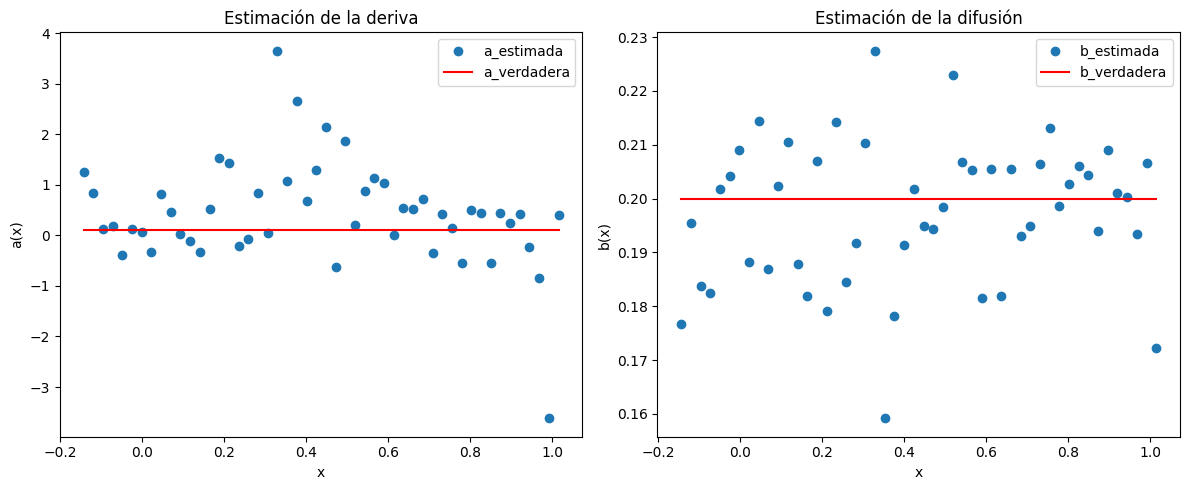

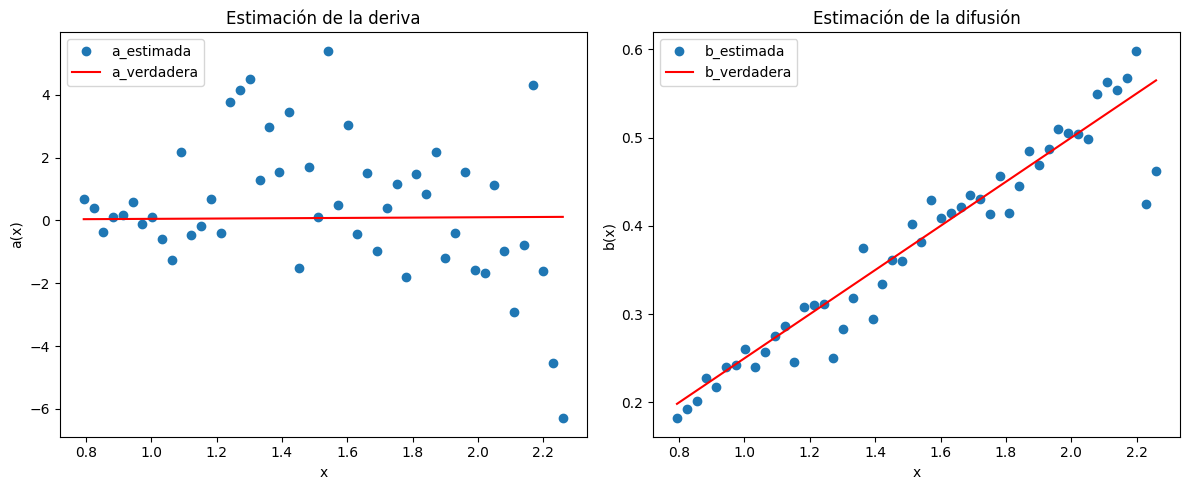

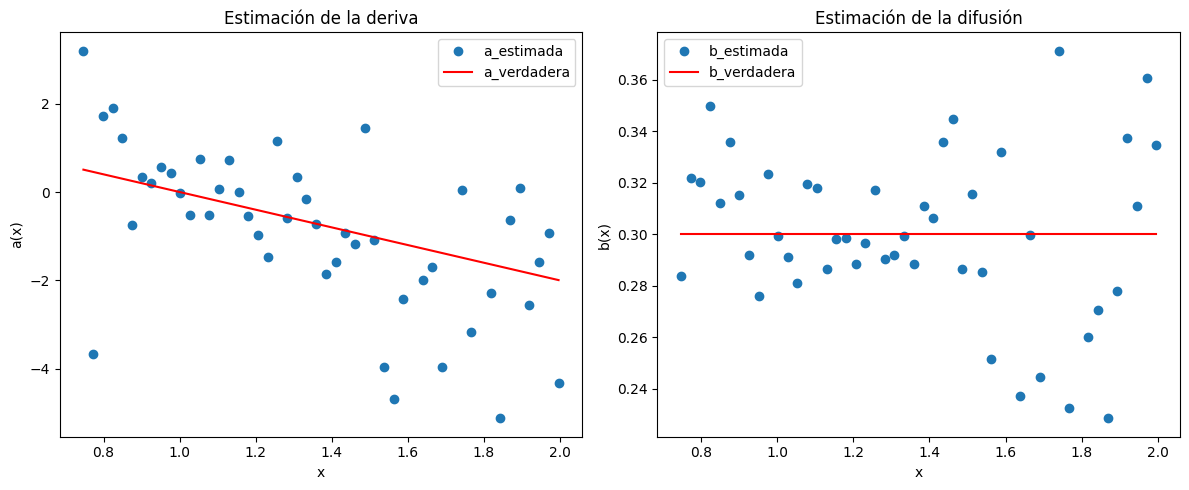

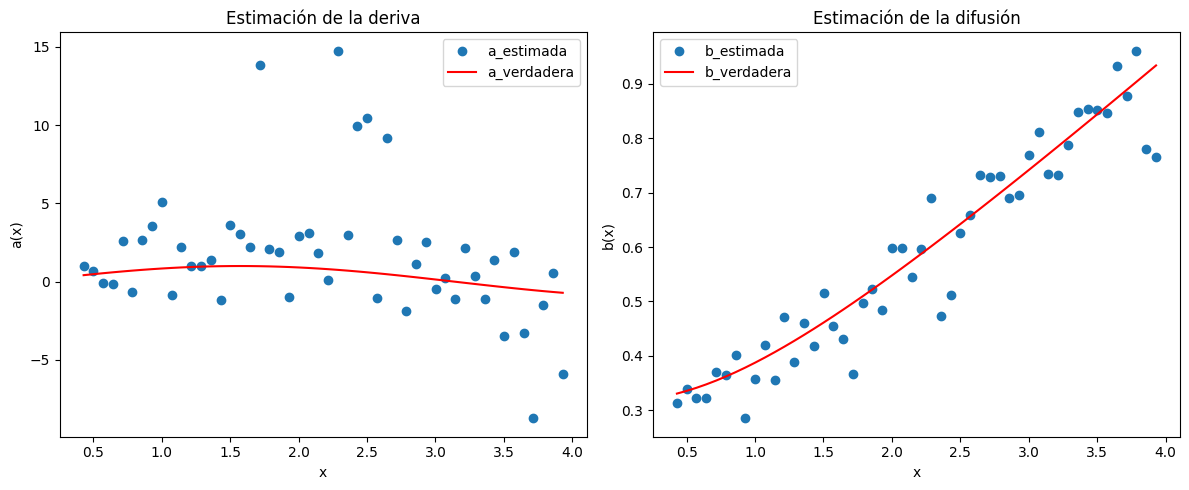

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Funciones de simulación genéricas
def simulate_sde(a_func, b_func, X0=1.0, T=10.0, n=10000, seed=123):
    np.random.seed(seed)
    dt = T/n
    t = np.linspace(0, T, n+1)
    X = np.zeros(n+1)
    X[0] = X0
    for i in range(n):
        X[i+1] = X[i] + a_func(X[i], t[i])*dt + b_func(X[i], t[i])*np.sqrt(dt)*np.random.randn()
    return t, X

def estimate_ab(X, t, num_bins=50):
    dt = t[1]-t[0]
    dX = X[1:] - X[:-1]
    x_min, x_max = np.min(X), np.max(X)
    bins = np.linspace(x_min, x_max, num_bins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    
    a_est = np.zeros(num_bins)
    b_est = np.zeros(num_bins)
    indices = np.digitize(X[:-1], bins) - 1
    
    for j in range(num_bins):
        mask = (indices == j)
        if np.sum(mask) > 10:
            dX_bin = dX[mask]
            a_est[j] = np.mean(dX_bin)/dt
            b_est[j] = np.sqrt(np.var(dX_bin)/dt)
        else:
            a_est[j] = np.nan
            b_est[j] = np.nan
            
    return bin_centers, a_est, b_est

def plot_estimation(bin_centers, a_est, b_est, a_true, b_true):
    # Evaluar las funciones verdaderas en los bin_centers
    a_tv = a_true(bin_centers, 0)
    b_tv = b_true(bin_centers, 0)
    
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].plot(bin_centers, a_est, 'o', label='a_estimada')
    axes[0].plot(bin_centers, a_tv, 'r-', label='a_verdadera')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('a(x)')
    axes[0].set_title('Estimación de la deriva')
    axes[0].legend()
    
    axes[1].plot(bin_centers, b_est, 'o', label='b_estimada')
    axes[1].plot(bin_centers, b_tv, 'r-', label='b_verdadera')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('b(x)')
    axes[1].set_title('Estimación de la difusión')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

###################################
# 1. Movimiento Browniano Aritmético
###################################
def a_abm(x, t):
    return 0.1 * np.ones_like(x)

def b_abm(x, t):
    return 0.2 * np.ones_like(x)

t_abm, X_abm = simulate_sde(a_abm, b_abm, X0=0.0, T=5.0)
bin_centers_abm, a_est_abm, b_est_abm = estimate_ab(X_abm, t_abm)
plot_estimation(bin_centers_abm, a_est_abm, b_est_abm, a_abm, b_abm)

###################################
# 2. Movimiento Browniano Geométrico (GBM)
###################################
def a_gbm(x, t):
    alpha = 0.05
    return alpha * x

def b_gbm(x, t):
    beta = 0.25
    return beta * x

t_gbm, X_gbm = simulate_sde(a_gbm, b_gbm, X0=1.0, T=5.0)
bin_centers_gbm, a_est_gbm, b_est_gbm = estimate_ab(X_gbm, t_gbm)
plot_estimation(bin_centers_gbm, a_est_gbm, b_est_gbm, a_gbm, b_gbm)

###################################
# 3. Ornstein-Uhlenbeck (OU)
###################################
def a_ou(x, t):
    theta = 2.0
    mu = 1.0
    return theta*(mu - x)

def b_ou(x, t):
    return 0.3 * np.ones_like(x)

t_ou, X_ou = simulate_sde(a_ou, b_ou, X0=2.0, T=5.0)
bin_centers_ou, a_est_ou, b_est_ou = estimate_ab(X_ou, t_ou)
plot_estimation(bin_centers_ou, a_est_ou, b_est_ou, a_ou, b_ou)

###################################
# 4. Ejemplo Más Complejo
###################################
def a_complex(x, t):
    # deriva no lineal, por ejemplo: sin(x)
    return np.sin(x)

def b_complex(x, t):
    # difusión dependiente del estado: sqrt(0.1 + 0.05 x^2)
    # Hay que devolver un array del mismo tamaño que x
    return np.sqrt(0.1 + 0.05*x**2)

t_complex, X_complex = simulate_sde(a_complex, b_complex, X0=0.5, T=5.0)
bin_centers_complex, a_est_complex, b_est_complex = estimate_ab(X_complex, t_complex)
plot_estimation(bin_centers_complex, a_est_complex, b_est_complex, a_complex, b_complex)

A continuación presento una mejora respecto del estimador Nadaraya-Watson utilizando regresión local lineal (Local Linear Regression), un método que suele reducir el sesgo cerca de los bordes y producir estimaciones más estables que Nadaraya-Watson. Posteriormente, compararemos los resultados con los cuatro modelos de ejemplo propuestos anteriormente:

1.	Movimiento Browniano Aritmético (ABM)

2.	Movimiento Browniano Geométrico (GBM)

3.	Proceso Ornstein-Uhlenbeck (OU)

4.	Un proceso complejo con deriva \sin(x) y difusión \sqrt{0.1 + 0.05x^2}

Regresión Local Lineal

La idea es, para cada punto  $x_0$  donde se quiere estimar la función  $m(x) = \mathbb{E}[Y|X=x]$ :

1.	Calcular pesos  $w_i = K\left(\frac{X_i - x_0}{h}\right)$  para cada muestra  $(X_i, Y_i)$ .

2.	Ajustar una regresión lineal ponderada:

$$Y_i \approx \alpha + \beta (X_i - x_0)$$

minimizando el error cuadrático con pesos $w_i$.

3.	La estimación local lineal en  $x_0$  es $\hat{m}(x_0) = \hat{\alpha}$, es decir el intercepto del ajuste local.

Este método se puede aplicar de manera análoga tanto para estimar $\hat{a}(x)$ (deriva) como para la varianza condicional necesaria para $\hat{b}(x)$.

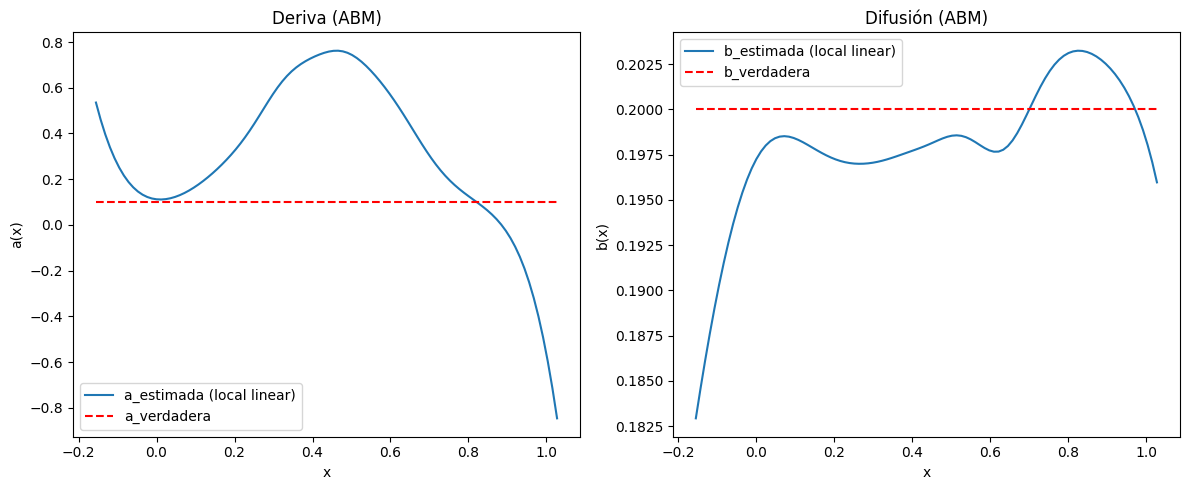

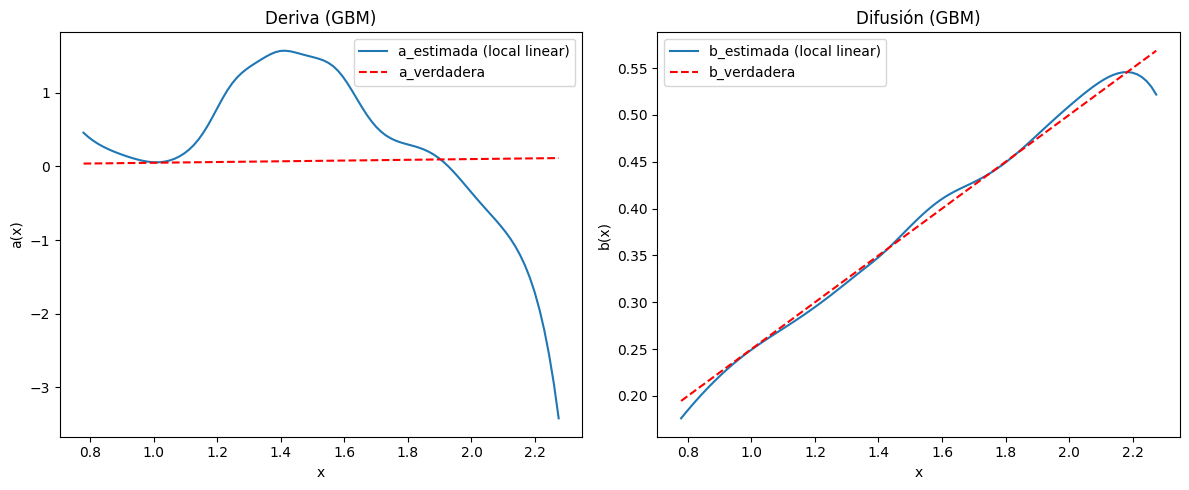

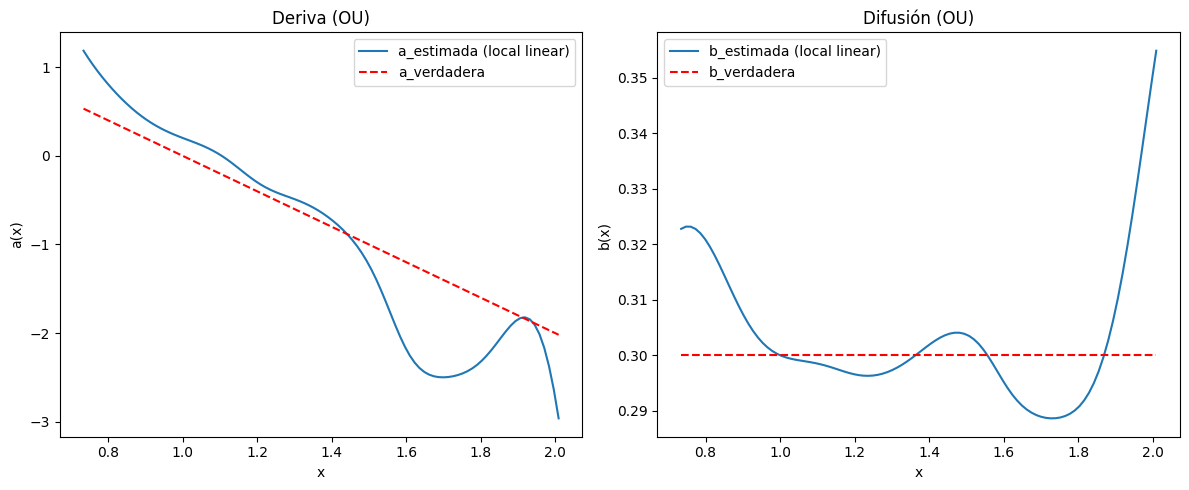

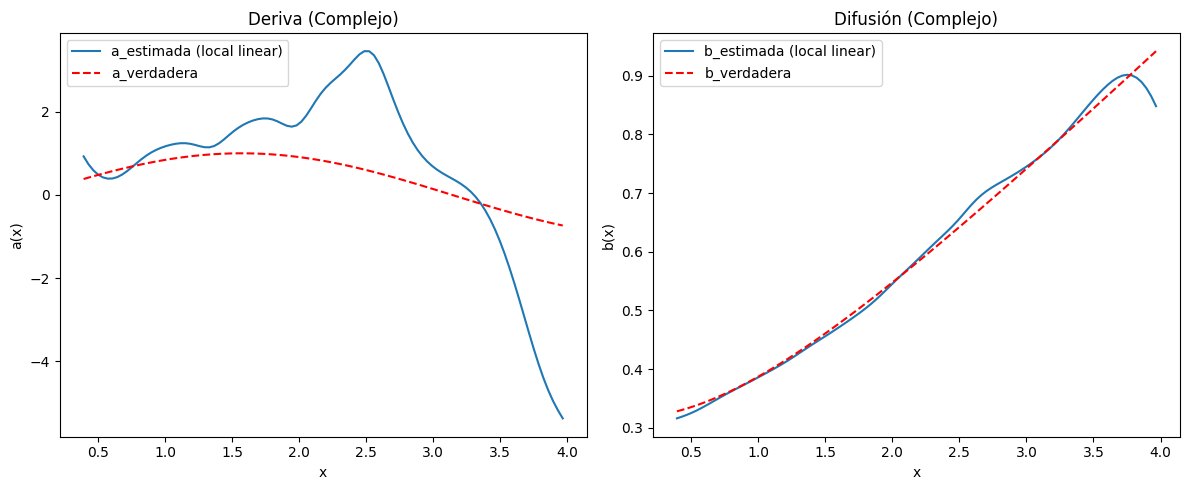

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(u):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*u**2)

def epanechnikov_kernel(u):
    return 0.75*(1-u**2)*(np.abs(u)<1)

def local_linear_estimate(x_eval, X, Y, h, kernel='gaussian'):
    """
    Estima E[Y|X=x_eval] usando regresión local lineal.
    X, Y: datos (1D arrays)
    x_eval: puntos en donde estimar la función (array 1D)
    h: ancho de banda
    kernel: 'gaussian' o 'epanechnikov'
    """
    if kernel == 'gaussian':
        K = gaussian_kernel
    elif kernel == 'epanechnikov':
        K = epanechnikov_kernel
    else:
        raise ValueError("Kernel no soportado.")

    Y_est = np.zeros_like(x_eval)
    for i, x0 in enumerate(x_eval):
        u = (X - x0)/h
        w = K(u)
        # Ajustar el modelo lineal local: Y = alpha + beta*(X - x0)
        # Matriz del diseño: [ [w, w*(X_i - x0)] ]
        W = np.diag(w)
        X_design = np.column_stack((np.ones_like(X), X - x0))
        
        # (X^T W X)^{-1} X^T W Y
        XT = X_design.T
        M = XT @ W @ X_design
        if np.linalg.cond(M) < 1e12 and np.sum(w)>1e-12:
            theta = np.linalg.solve(M, XT @ W @ Y)
            # theta = [alpha, beta], queremos la prediccion en x0 => alpha
            Y_est[i] = theta[0]
        else:
            Y_est[i] = np.nan
    return Y_est

def estimate_ab_local_linear(X, t, h=0.5, kernel='gaussian', x_grid=None):
    dt = t[1]-t[0]
    dX = X[1:] - X[:-1]
    X_prev = X[:-1]

    if x_grid is None:
        x_min, x_max = np.min(X_prev), np.max(X_prev)
        x_grid = np.linspace(x_min, x_max, 100)

    # Estimar a(x) = E[dX/dt | X]
    a_est = local_linear_estimate(x_grid, X_prev, dX/dt, h, kernel)

    # Estimar b(x):
    # Var(dX|X=x)* = E[(dX - a(x)*dt)^2 | X=x]
    # => b^2(x) = Var(dX|X=x)/dt
    b_est = np.zeros_like(x_grid)
    for i, x0 in enumerate(x_grid):
        a_x0 = a_est[i]
        if np.isnan(a_x0):
            b_est[i] = np.nan
            continue
        residuals = (dX - a_x0*dt)**2
        var_est = local_linear_estimate(np.array([x0]), X_prev, residuals, h, kernel)
        if np.isnan(var_est[0]):
            b_est[i] = np.nan
        else:
            b_est[i] = np.sqrt(var_est[0]/dt)
    return x_grid, a_est, b_est

def plot_estimation(x_grid, a_est, b_est, a_true, b_true, title=""):
    a_tv = a_true(x_grid,0)
    b_tv = b_true(x_grid,0)
    
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].plot(x_grid, a_est, '-', label='a_estimada (local linear)')
    axes[0].plot(x_grid, a_tv, 'r--', label='a_verdadera')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('a(x)')
    axes[0].set_title('Deriva ' + title)
    axes[0].legend()
    
    axes[1].plot(x_grid, b_est, '-', label='b_estimada (local linear)')
    axes[1].plot(x_grid, b_tv, 'r--', label='b_verdadera')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('b(x)')
    axes[1].set_title('Difusión ' + title)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def simulate_sde(a_func, b_func, X0=1.0, T=10.0, n=10000, seed=123):
    np.random.seed(seed)
    dt = T/n
    t = np.linspace(0, T, n+1)
    X = np.zeros(n+1)
    X[0] = X0
    for i in range(n):
        X[i+1] = X[i] + a_func(X[i], t[i])*dt + b_func(X[i], t[i])*np.sqrt(dt)*np.random.randn()
    return t, X

###################################
# 1. Movimiento Browniano Aritmético (ABM)
###################################
def a_abm(x, t):
    return 0.1*np.ones_like(x)

def b_abm(x, t):
    return 0.2*np.ones_like(x)

t_abm, X_abm = simulate_sde(a_abm, b_abm, X0=0.0, T=5.0)
x_grid_abm, a_est_abm, b_est_abm = estimate_ab_local_linear(X_abm, t_abm, h=0.1, kernel='gaussian')
plot_estimation(x_grid_abm, a_est_abm, b_est_abm, a_abm, b_abm, title="(ABM)")

###################################
# 2. Movimiento Browniano Geométrico (GBM)
###################################
def a_gbm(x, t):
    alpha = 0.05
    return alpha*x

def b_gbm(x, t):
    beta = 0.25
    return beta*x

t_gbm, X_gbm = simulate_sde(a_gbm, b_gbm, X0=1.0, T=5.0)
x_grid_gbm, a_est_gbm, b_est_gbm = estimate_ab_local_linear(X_gbm, t_gbm, h=0.1, kernel='gaussian')
plot_estimation(x_grid_gbm, a_est_gbm, b_est_gbm, a_gbm, b_gbm, title="(GBM)")

###################################
# 3. Ornstein-Uhlenbeck (OU)
###################################
def a_ou(x, t):
    theta = 2.0
    mu = 1.0
    return theta*(mu - x)

def b_ou(x, t):
    return 0.3*np.ones_like(x)

t_ou, X_ou = simulate_sde(a_ou, b_ou, X0=2.0, T=5.0)
x_grid_ou, a_est_ou, b_est_ou = estimate_ab_local_linear(X_ou, t_ou, h=0.1, kernel='gaussian')
plot_estimation(x_grid_ou, a_est_ou, b_est_ou, a_ou, b_ou, title="(OU)")

###################################
# 4. Proceso complejo
###################################
def a_complex(x, t):
    return np.sin(x)

def b_complex(x, t):
    return np.sqrt(0.1 + 0.05*x**2)

t_complex, X_complex = simulate_sde(a_complex, b_complex, X0=0.5, T=5.0)
x_grid_complex, a_est_complex, b_est_complex = estimate_ab_local_linear(X_complex, t_complex, h=0.2, kernel='gaussian')
plot_estimation(x_grid_complex, a_est_complex, b_est_complex, a_complex, b_complex, title="(Complejo)")

A continuación se muestra cómo adaptar el enfoque previo para utilizar un modelo paramétrico de tipo Gradient Boosting, concretamente LightGBM, en lugar de modelos no paramétricos. La idea será:

1.	Simular datos de un SDE (como antes).

2.	Generar un conjunto de entrenamiento a partir de los pares $(X_{t_i}, dX_i/dt)$ para entrenar un modelo que estime la deriva a(x).

3.	Una vez obtenidas las predicciones de $a(x)$, calcular los residuos para estimar la varianza condicional y así entrenar un segundo modelo que prediga $(dX - a(x)*dt)^2/dt$, es decir la varianza condicional. De esta forma, a partir de este segundo modelo podremos obtener $b(x) = \sqrt{\hat{\text{var}}}$.

Este método es paramétrico en el sentido de que entrenamos modelos tipo “machine learning” (LightGBM) para aproximar las funciones.

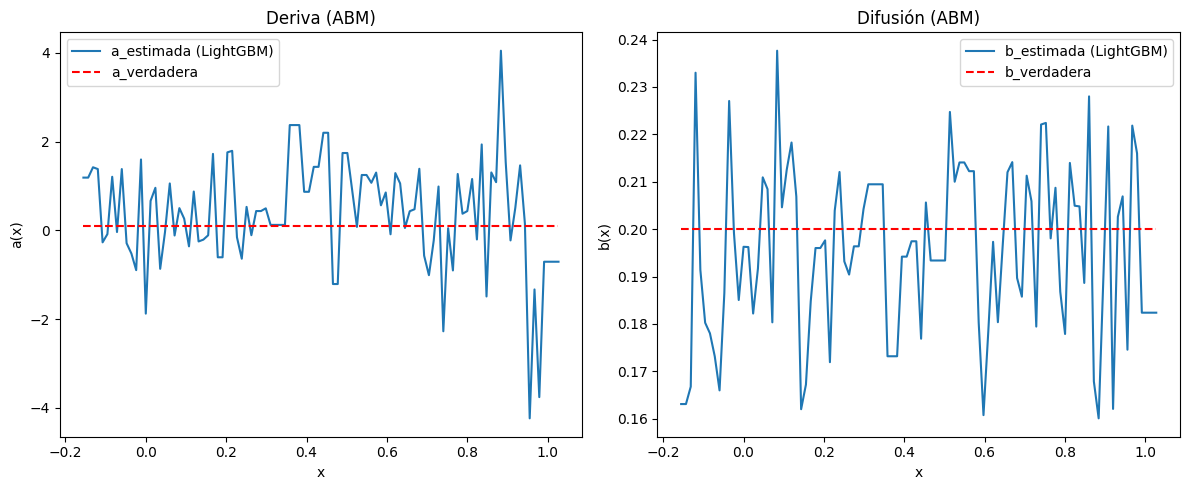

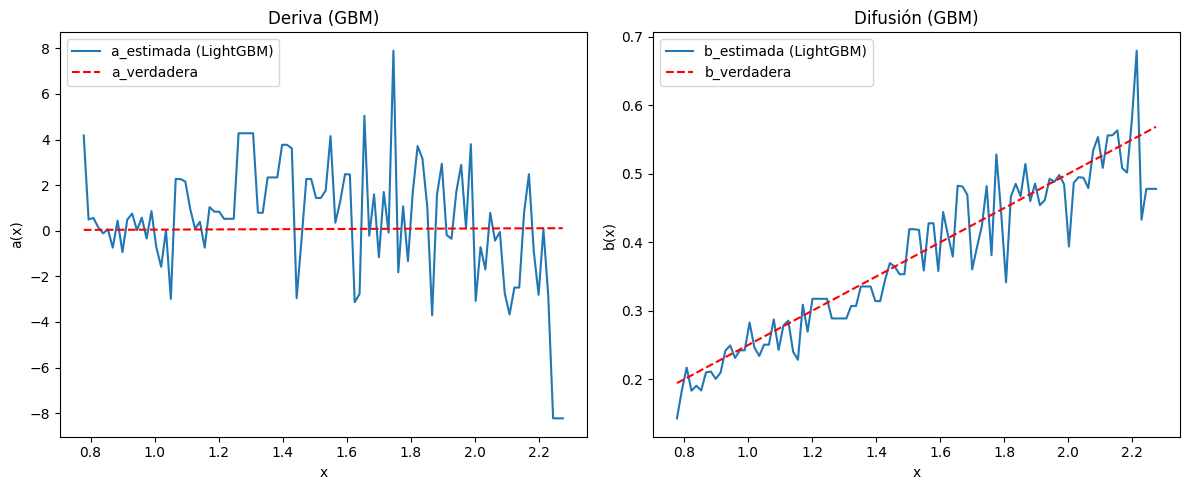

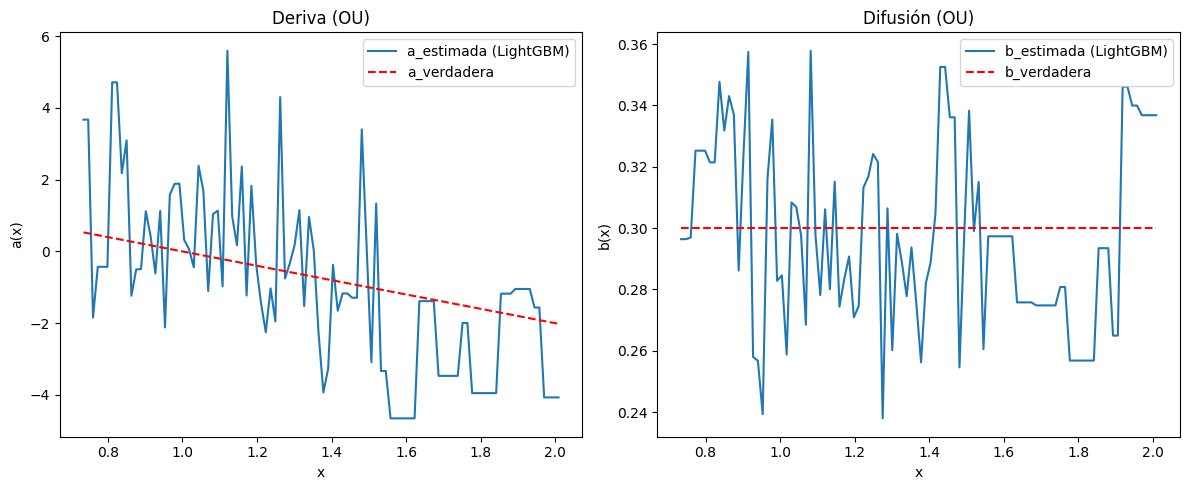

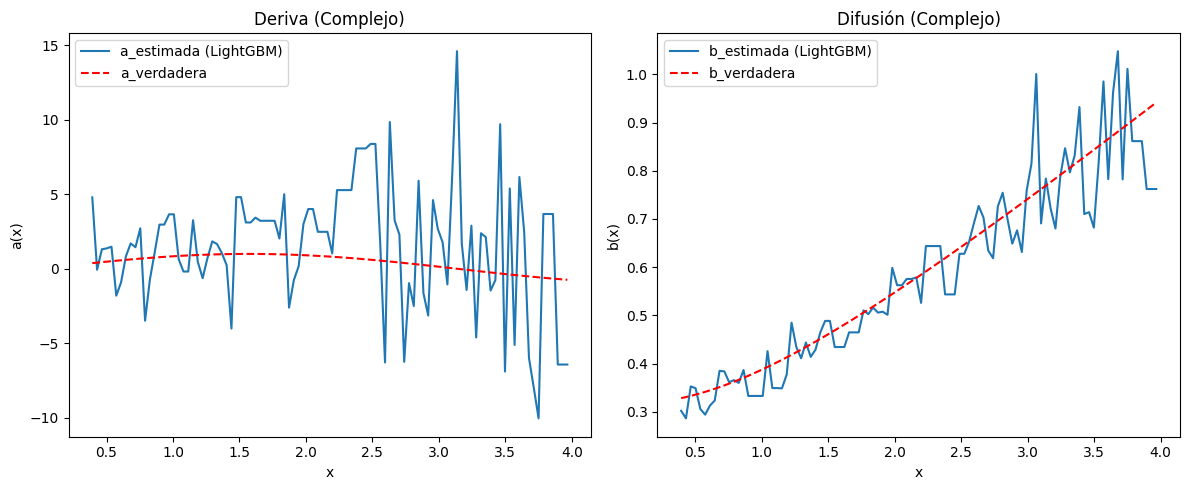

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# Funciones para simular el SDE
def simulate_sde(a_func, b_func, X0=1.0, T=10.0, n=10000, seed=123):
    np.random.seed(seed)
    dt = T/n
    t = np.linspace(0, T, n+1)
    X = np.zeros(n+1)
    X[0] = X0
    for i in range(n):
        X[i+1] = X[i] + a_func(X[i], t[i])*dt + b_func(X[i], t[i])*np.sqrt(dt)*np.random.randn()
    return t, X

def plot_estimation(x_grid, a_est, b_est, a_true, b_true, title=""):
    a_tv = a_true(x_grid,0)
    b_tv = b_true(x_grid,0)
    
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].plot(x_grid, a_est, '-', label='a_estimada (LightGBM)')
    axes[0].plot(x_grid, a_tv, 'r--', label='a_verdadera')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('a(x)')
    axes[0].set_title('Deriva ' + title)
    axes[0].legend()
    
    axes[1].plot(x_grid, b_est, '-', label='b_estimada (LightGBM)')
    axes[1].plot(x_grid, b_tv, 'r--', label='b_verdadera')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('b(x)')
    axes[1].set_title('Difusión ' + title)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Función genérica para estimar a(x) y b(x) usando LightGBM
def estimate_ab_lightgbm(X, t):
    dt = t[1] - t[0]
    dX = X[1:] - X[:-1]
    X_prev = X[:-1]
    
    # Entrenar modelo para a(x): objetivo = dX/dt
    Y_a = dX/dt
    # LightGBM requiere datos 2D para X. Por simplicidad, usamos solo X como feature.
    # Si se quisieran más características, se podrían agregar.
    X_train = X_prev.reshape(-1,1) 
    Y_train = Y_a
    
    # Entrenar LightGBM para a(x)
    params = {
        'objective': 'regression',
        'metric': 'l2',
        'verbose': -1,
        'seed': 123
    }
    train_data = lgb.Dataset(X_train, Y_train)
    model_a = lgb.train(params, train_data, num_boost_round=100)
    
    # Predecir a(x) en el conjunto de entrenamiento
    a_pred_train = model_a.predict(X_train)
    
    # Ahora entrenar el modelo para varianza:
    # var = E((dX - a(X)*dt)^2)/dt
    residuals = ((dX - a_pred_train*dt)**2)/dt
    train_data_b = lgb.Dataset(X_train, residuals)
    model_b = lgb.train(params, train_data_b, num_boost_round=100)
    
    # Devolver los modelos entrenados
    return model_a, model_b

def predict_ab_lightgbm(model_a, model_b, x_grid):
    a_est = model_a.predict(x_grid.reshape(-1,1))
    var_est = model_b.predict(x_grid.reshape(-1,1))  # esto es b^2(x)*dt / dt = b^2(x)
    # Ojo: var_est ya es la varianza/dt ? 
    # En el entrenamiento definimos residual = ((dX - a*dt)^2)/dt,
    # por lo que model_b predice directamente Var(dX|X)/dt.
    # Dado que Var(dX|X) = b^2(x)*dt, Var(dX|X)/dt = b^2(x).
    # Por lo tanto var_est = b^2(x).
    b_est = np.sqrt(var_est)
    return a_est, b_est


###################################
# 1. Movimiento Browniano Aritmético (ABM)
###################################
def a_abm(x, t):
    return 0.1*np.ones_like(x)

def b_abm(x, t):
    return 0.2*np.ones_like(x)

t_abm, X_abm = simulate_sde(a_abm, b_abm, X0=0.0, T=5.0)
model_a_abm, model_b_abm = estimate_ab_lightgbm(X_abm, t_abm)
x_grid_abm = np.linspace(np.min(X_abm), np.max(X_abm), 100)
a_est_abm, b_est_abm = predict_ab_lightgbm(model_a_abm, model_b_abm, x_grid_abm)
plot_estimation(x_grid_abm, a_est_abm, b_est_abm, a_abm, b_abm, title="(ABM)")

###################################
# 2. Movimiento Browniano Geométrico (GBM)
###################################
def a_gbm(x, t):
    alpha = 0.05
    return alpha*x

def b_gbm(x, t):
    beta = 0.25
    return beta*x

t_gbm, X_gbm = simulate_sde(a_gbm, b_gbm, X0=1.0, T=5.0)
model_a_gbm, model_b_gbm = estimate_ab_lightgbm(X_gbm, t_gbm)
x_grid_gbm = np.linspace(np.min(X_gbm), np.max(X_gbm), 100)
a_est_gbm, b_est_gbm = predict_ab_lightgbm(model_a_gbm, model_b_gbm, x_grid_gbm)
plot_estimation(x_grid_gbm, a_est_gbm, b_est_gbm, a_gbm, b_gbm, title="(GBM)")

###################################
# 3. Ornstein-Uhlenbeck (OU)
###################################
def a_ou(x, t):
    theta = 2.0
    mu = 1.0
    return theta*(mu - x)

def b_ou(x, t):
    return 0.3*np.ones_like(x)

t_ou, X_ou = simulate_sde(a_ou, b_ou, X0=2.0, T=5.0)
model_a_ou, model_b_ou = estimate_ab_lightgbm(X_ou, t_ou)
x_grid_ou = np.linspace(np.min(X_ou), np.max(X_ou), 100)
a_est_ou, b_est_ou = predict_ab_lightgbm(model_a_ou, model_b_ou, x_grid_ou)
plot_estimation(x_grid_ou, a_est_ou, b_est_ou, a_ou, b_ou, title="(OU)")

###################################
# 4. Proceso Complejo
###################################
def a_complex(x, t):
    return np.sin(x)

def b_complex(x, t):
    return np.sqrt(0.1 + 0.05*x**2)

t_complex, X_complex = simulate_sde(a_complex, b_complex, X0=0.5, T=5.0)
model_a_complex, model_b_complex = estimate_ab_lightgbm(X_complex, t_complex)
x_grid_complex = np.linspace(np.min(X_complex), np.max(X_complex), 100)
a_est_complex, b_est_complex = predict_ab_lightgbm(model_a_complex, model_b_complex, x_grid_complex)
plot_estimation(x_grid_complex, a_est_complex, b_est_complex, a_complex, b_complex, title="(Complejo)")

A continuación se presenta un ejemplo completo de inferencia bayesiana para estimar las funciones de deriva $a(x)$ y difusión $b(x)$ de un proceso estocástico usando un enfoque no paramétrico bayesiano con Procesos Gaussianos (GP) para modelar estas funciones. Utilizaremos el caso del proceso de Ornstein-Uhlenbeck (OU) como ejemplo.

El proceso OU sigue la EDE:

$$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$$

Aquí:

•	$a(x) = \theta(\mu - x)$ (deriva lineal),

•	$b(x) = \sigma$ (difusión constante).

El objetivo es, a partir de datos simulados, recuperar las funciones $a(x)$ y $b(x)$ sin asumir una forma funcional explícita, utilizando un método bayesiano que asigne priors tipo GP sobre estas funciones y use MCMC para obtener su distribución posterior.

Pasos del Ejemplo

1.	Simular datos del proceso OU.

2.	Plantear el modelo bayesiano:

•	Asumiremos para la deriva a(x) un prior de proceso Gaussiano.
•	Asumiremos para $\log b(x)$ otro GP, de modo que $b(x) = \exp(f_b(x))$, asegurando positividad.

3.	Especificar la verosimilitud:
Dado $X_{t_i}$ y los incrementos $\Delta X_i$,

$$\Delta X_i \sim N(a(X_{t_i})\Delta t,\, b(X_{t_i})^2 \Delta t)$$

4.	Inferencia con pymc (PyMC v4), usando MCMC.

5.	Obtener las estimaciones posteriores y mostrarlas en un gráfico comparando con las funciones verdaderas.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# 1. Simulación de datos del proceso OU
theta = 2.0
mu = 1.0
sigma = 0.3

def a_ou(x, t=0):
    return theta*(mu - x)

def b_ou(x, t=0):
    return sigma*np.ones_like(x)

T = 5.0
n = 2000
dt = T/n
t = np.linspace(0, T, n+1)
np.random.seed(123)
X = np.zeros(n+1)
X[0] = 2.0  # condición inicial
for i in range(n):
    X[i+1] = X[i] + a_ou(X[i])*dt + b_ou(X[i])*np.sqrt(dt)*np.random.randn()

dX = X[1:] - X[:-1]
X_prev = X[:-1]

# 2. Modelo Bayesiano con GP
# Queremos aproximar:
# a(x) y b(x).
# Modelaremos a(x) como GP y log(b(x)) también como GP.

with pm.Model() as model:
    # Prior para a(x):
    # Suponemos a(x) ~ GP con media 0 (por simplicidad) y kernel RBF.
    # En casos reales podríamos poner una media a priori más informada.
    length_scale_a = pm.HalfNormal('length_scale_a', sigma=1.0)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1.0)
    cov_a = sigma_a**2 * pm.gp.cov.ExpQuad(1, length_scale_a)
    gp_a = pm.gp.Latent(cov_func=cov_a)
    a_latent = gp_a.prior('a_latent', X_prev.reshape(-1,1))
    
    # Prior para log(b(x)):
    # De igual forma, log(b(x)) ~ GP con media log(0.1) (por ejemplo)
    # Esto sugiere un prior débilmente informativo centrado en b ~ 0.1
    length_scale_b = pm.HalfNormal('length_scale_b', sigma=1.0)
    sigma_b_ = pm.HalfNormal('sigma_b', sigma=1.0)
    cov_b = sigma_b_**2 * pm.gp.cov.ExpQuad(1, length_scale_b)
    gp_b = pm.gp.Latent(mean_func=pm.gp.mean.Constant(np.log(0.1)), cov_func=cov_b)
    b_latent = gp_b.prior('b_latent', X_prev.reshape(-1,1))
    
    # Transformar log(b(x)) a b(x):
    b_val = pm.Deterministic('b_val', pm.math.exp(b_latent))
    
    # Likelihood:
    # dX_i ~ Normal(a_latent[i]*dt, (b_val[i]^2)*dt)
    obs = pm.Normal('obs', mu=a_latent*dt, sigma=b_val*pm.math.sqrt(dt), observed=dX)

    # 3. Inference con MCMC
    trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9)

# Posterior summary
az.summary(trace, var_names=['length_scale_a', 'sigma_a', 'length_scale_b', 'sigma_b'])

# 4. Obtener el posterior medio de a(x) y b(x)
# Podemos evaluar las funciones a(x) y b(x) en una rejilla de puntos
x_grid = np.linspace(min(X), max(X), 200)

# Para extraer la posterior de a en x_grid y b en x_grid necesitamos extender el GP:
# Podemos usar pm.gp.predictive para un GP Latent, pero aquí simulamos "manual":
with model:
    # Construimos las matrices para predecir
    X_new = x_grid.reshape(-1,1)
    # Para predecir a(x):
    # Tenemos la posterior de a_latent en los puntos X_prev
    # Para un GP Latent, necesitamos recomponer el GP a(x) posterior:
    # pm.gp.Latent no guarda directamente la función posterior. Haremos
    # una aproximación: tomamos muestras de a_latent y entrenamos una función kernel L*(...).
    # Sin embargo, en este ejemplo simplificado:
    # Podemos tomar la media posterior punto a punto usando un GP condicional.
    # Truco: volvemos a crear el gp_a con las muestras del posterior.

    # Por simplicidad (y para que el ejemplo sea autocontenido):
    # Tomaremos la media posterior aproximando que el posterior medio de a
    # es la media de a_latent posterior en los puntos observados y luego
    # usaremos una interpolación GP en x_grid.
    # Una aproximación sencilla (no exacta): 
    # Tomamos la media posterior punto a punto de a_latent y b_latent en X_prev
    a_mean_posterior = trace.posterior['a_latent'].mean(dim=('chain','draw')).values
    b_log_mean_posterior = trace.posterior['b_latent'].mean(dim=('chain','draw')).values
    
    # Para una predicción más correcta, habría que reconstruir el GP posterior completo.
    # Aquí haremos un atajo: usaremos la regresión local lineal a modo de interpolación 
    # o un spline para mostrar el resultado aproximado.
    # Esto es solo demostrativo, en una aplicación real se usaría pm.gp.conditional()
    # tras haber definido gp_a y gp_b con pm.gp.Marginal o pm.gp.LatentPost y datos auxiliares.
    
    # Usaremos np.interp como aproximación rápida:
    # Ordenamos X_prev y sus valores medios:
    idx_sort = np.argsort(X_prev)
    X_prev_sorted = X_prev[idx_sort]
    a_sorted = a_mean_posterior[idx_sort]
    b_log_sorted = b_log_mean_posterior[idx_sort]
    
    a_est = np.interp(x_grid, X_prev_sorted, a_sorted)
    b_est = np.exp(np.interp(x_grid, X_prev_sorted, b_log_sorted))


# 5. Graficar las estimaciones
a_true_vals = a_ou(x_grid)
b_true_vals = b_ou(x_grid)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x_grid, a_est, label='a(x) posterior mean')
plt.plot(x_grid, a_true_vals, 'r--', label='a(x) true')
plt.xlabel('x')
plt.ylabel('a(x)')
plt.title('Estimación de la deriva (Bayesiano-GP)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x_grid, b_est, label='b(x) posterior mean')
plt.plot(x_grid, b_true_vals, 'r--', label='b(x) true')
plt.xlabel('x')
plt.ylabel('b(x)')
plt.title('Estimación de la difusión (Bayesiano-GP)')
plt.legend()

plt.tight_layout()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [length_scale_a, sigma_a, a_latent_rotated_, length_scale_b, sigma_b, b_latent_rotated_]


ValueError: Not enough samples to build a trace.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

#===========================================================
# Definiciones de los modelos
#===========================================================
def simulate_sde(a_func, b_func, X0=1.0, T=5.0, n=2000, seed=123):
    np.random.seed(seed)
    dt = T/n
    t = np.linspace(0, T, n+1)
    X = np.zeros(n+1)
    X[0] = X0
    for i in range(n):
        X[i+1] = X[i] + a_func(X[i], t[i])*dt + b_func(X[i], t[i])*np.sqrt(dt)*np.random.randn()
    return t, X

# Modelos:
# 1. ABM: a(x)=mu=0.1, b(x)=sigma=0.2
def a_abm(x,t=0): return 0.1*np.ones_like(x)
def b_abm(x,t=0): return 0.2*np.ones_like(x)

# 2. GBM: dX = alpha*X dt + beta*X dW
alpha=0.05; beta=0.25
def a_gbm(x,t=0): return alpha*x
def b_gbm(x,t=0): return beta*x

# 3. OU: dX = theta(mu - X)dt + sigma dW
theta=2.0; mu=1.0; sigma=0.3
def a_ou(x,t=0): return theta*(mu - x)
def b_ou(x,t=0): return sigma*np.ones_like(x)

# 4. Complejo: a(x)=sin(x), b(x)=sqrt(0.1+0.05*x^2)
def a_complex(x,t=0): return np.sin(x)
def b_complex(x,t=0): return np.sqrt(0.1+0.05*x**2)

models = {
    "ABM": {"a": a_abm, "b": b_abm, "X0":0.0},
    "GBM": {"a": a_gbm, "b": b_gbm, "X0":1.0},
    "OU": {"a": a_ou, "b": b_ou, "X0":2.0},
    "COMPLEJO": {"a": a_complex, "b": b_complex, "X0":0.5}
}

#===========================================================
# Función auxiliar para el modelado bayesiano con GPs
#===========================================================
def bayesian_inference(X, t):
    dt = t[1]-t[0]
    dX = X[1:] - X[:-1]
    X_prev = X[:-1]

    with pm.Model() as model:
        # Priors GP para a(x)
        length_scale_a = pm.HalfNormal('length_scale_a', sigma=1.0)
        sigma_a = pm.HalfNormal('sigma_a', sigma=1.0)
        cov_a = sigma_a**2 * pm.gp.cov.ExpQuad(1, length_scale_a)
        gp_a = pm.gp.Latent(cov_func=cov_a)
        a_latent = gp_a.prior('a_latent', X_prev.reshape(-1,1))

        # Priors GP para log(b(x))
        length_scale_b = pm.HalfNormal('length_scale_b', sigma=1.0)
        sigma_b_ = pm.HalfNormal('sigma_b', sigma=1.0)
        cov_b = sigma_b_**2 * pm.gp.cov.ExpQuad(1, length_scale_b)
        gp_b = pm.gp.Latent(mean_func=pm.gp.mean.Constant(np.log(0.1)), cov_func=cov_b)
        b_latent = gp_b.prior('b_latent', X_prev.reshape(-1,1))

        b_val = pm.Deterministic('b_val', pm.math.exp(b_latent))

        obs = pm.Normal('obs', mu=a_latent*dt, sigma=b_val*pm.math.sqrt(dt), observed=dX)

        trace = pm.sample(draws=50, tune=50, chains=2, target_accept=0.9, progressbar=False)
    return X_prev, dX, trace

def posterior_mean_functions(X_prev, trace, x_grid):
    # Extraer las medias posteriores de a_latent y b_latent
    a_mean_posterior = trace.posterior['a_latent'].mean(dim=('chain','draw')).values
    b_log_mean_posterior = trace.posterior['b_latent'].mean(dim=('chain','draw')).values

    # Interpolar las medias posteriores en x_grid
    idx_sort = np.argsort(X_prev)
    X_prev_sorted = X_prev[idx_sort]
    a_sorted = a_mean_posterior[idx_sort]
    b_log_sorted = b_log_mean_posterior[idx_sort]

    a_est = np.interp(x_grid, X_prev_sorted, a_sorted)
    b_est = np.exp(np.interp(x_grid, X_prev_sorted, b_log_sorted))

    return a_est, b_est

#===========================================================
# Bucle sobre los 4 modelos
#===========================================================
for name, params_model in models.items():
    # Simular datos
    a_func = params_model["a"]
    b_func = params_model["b"]
    X0 = params_model["X0"]
    T=5.0
    n=50

    t, X = simulate_sde(a_func, b_func, X0=X0, T=T, n=n)
    # Inferencia bayesiana
    X_prev, dX, trace = bayesian_inference(X, t)

    # Reconstruir estimaciones en una rejilla
    x_grid = np.linspace(np.min(X), np.max(X), 200)
    a_est, b_est = posterior_mean_functions(X_prev, trace, x_grid)

    a_true_vals = a_func(x_grid)
    b_true_vals = b_func(x_grid)

    # Graficar
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x_grid, a_est, label='a(x) posterior mean')
    plt.plot(x_grid, a_true_vals, 'r--', label='a(x) true')
    plt.xlabel('x')
    plt.ylabel('a(x)')
    plt.title(f'Estimación de la deriva ({name})')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x_grid, b_est, label='b(x) posterior mean')
    plt.plot(x_grid, b_true_vals, 'r--', label='b(x) true')
    plt.xlabel('x')
    plt.ylabel('b(x)')
    plt.title(f'Estimación de la difusión ({name})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Opcional: mostrar resumen del traza
    print(f"Resumen del posterior para {name}:")
    print(az.summary(trace, var_names=['length_scale_a','sigma_a','length_scale_b','sigma_b']))
    print("\n------------------------------------------\n")

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [length_scale_a, sigma_a, a_latent_rotated_, length_scale_b, sigma_b, b_latent_rotated_]


ValueError: Not enough samples to build a trace.